In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import os 
import glob

# Create a custom color map from white to black
white_black_cmap = LinearSegmentedColormap.from_list('white_black', ['white', 'black'], N=256)


In [95]:
def merge_seeds(file_name_pattern='CUB_results_s*_hessian_exact.csv', data_dir='./logs/ISR_hessian_results_ViT-B_rescaled'):
    # Create the full pattern for glob
    full_pattern = os.path.join(data_dir, file_name_pattern)

    # Use glob to get all file paths matching the pattern
    all_files = glob.glob(full_pattern)

    # Initialize an empty list to hold the dataframes
    df_list = []

    # Loop through the files, read each into a dataframe, and append it to the list
    for file_path in all_files:
        df = pd.read_csv(file_path)
        df_list.append(df)

    # Concatenate all the dataframes in the list
    merged_df = pd.concat(df_list, ignore_index=True)
    if 'penalty_anneal_iters' not in merged_df.columns:
        merged_df['penalty_anneal_iters'] = 0
    if 'fishr' in file_name_pattern:
        merged_df = merged_df[['dataset','seed','split','method','ISR_class','ISR_scale','num_iter', 'ema','lambda','penalty_anneal_iters', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc']]
    else:
        merged_df = merged_df[['dataset','seed','split','method','ISR_class','ISR_scale','num_iter', 'gradient_alpha', 'hessian_beta','penalty_anneal_iters', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc']]
    if 'CUB' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==300]
    elif 'CelebA' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==50]
    elif 'MultiNLI' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==3]
    if 'fishr' in file_name_pattern:
        grouped = merged_df.groupby(['dataset', 'split', 'method', 'ISR_class', 'ISR_scale',
                                     'num_iter','ema','lambda','penalty_anneal_iters']).agg({
            'avg_acc': ['mean', 'sem'],
            'worst_acc': ['mean', 'sem']
        })
    else:
        merged_df.fillna(0, inplace=True)
        grouped = merged_df.groupby(['dataset', 'split', 'method', 'ISR_class', 'ISR_scale',
                                'num_iter', 'gradient_alpha', 'hessian_beta','penalty_anneal_iters']).agg({
            'avg_acc': ['mean', 'sem'],
            'worst_acc': ['mean', 'sem']
        })
    # Renaming the columns for clarity
    grouped.columns = ['avg_acc_mean', 'avg_acc_sem', 'worst_acc_mean', 'worst_acc_sem']
    # Resetting the index if you want the grouped columns back as regular columns
    grouped = grouped.reset_index()
    # cleaned_grouped = grouped.dropna(subset=['avg_acc_sem', 'worst_acc_sem'])
    cleaned_grouped = grouped
    # Display the cleaned DataFrame
    # print(cleaned_grouped)
    val = cleaned_grouped[cleaned_grouped['split'] == 'val']
    test = cleaned_grouped[cleaned_grouped['split'] == 'test']
    num_runs = len(all_files)
    dataset = file_name_pattern.split('_')[0]
    if 'fishr' in file_name_pattern:
        val.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_fishr_val.csv', index=False)
        test.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_fishr_test.csv', index=False)
    else:
        val.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_val.csv', index=False)
        test.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_test.csv', index=False)
    # print(f"Saved {dataset}_{num_runs}runs_val.csv and {dataset}_{num_runs}runs_test.csv in {data_dir}")
    return val, test

In [105]:
merge_seeds(file_name_pattern='CUB_results_s*_hessian_exact.csv', data_dir='./logs/ISR_hessian_results_ViT-B_rescaled')
merge_seeds(file_name_pattern='CelebA_results_s*_hessian_exact.csv', data_dir='./logs/ISR_hessian_results_ViT-B_rescaled')
merge_seeds(file_name_pattern='MultiNLI_results_s*_hessian_exact.csv', data_dir='./logs/ISR_hessian_results_bert_rescaled')


# Example DataFrame
img_data_dir = './logs/ISR_Hessian_results_ViT-B_rescaled'
text_data_dir = './logs/ISR_Hessian_results_bert_rescaled'
cub_file = 'CUB_3runs_val.csv'
celeba_file = 'CelebA_1runs_val.csv'
multinli_file = 'MultiNLI_5runs_val.csv'


# df = pd.read_csv(os.path.join(img_data_dir, cub_file))
# df = pd.read_csv(os.path.join(img_data_dir, celeba_file))
df = pd.read_csv(os.path.join(text_data_dir, multinli_file))

if df['dataset'].iloc[0] == 'CUB':
    acc_min, acc_max = 0.8, 0.9
elif df['dataset'].iloc[0] == 'CelebA':
    acc_min, acc_max = 0.5, 0.70
elif df['dataset'].iloc[0] == 'MultiNLI':
    acc_min, acc_max = 0.5, 0.7
# Creating a pivot table, averaging over 'penalty_anneal_iters'
pivot_df = df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')


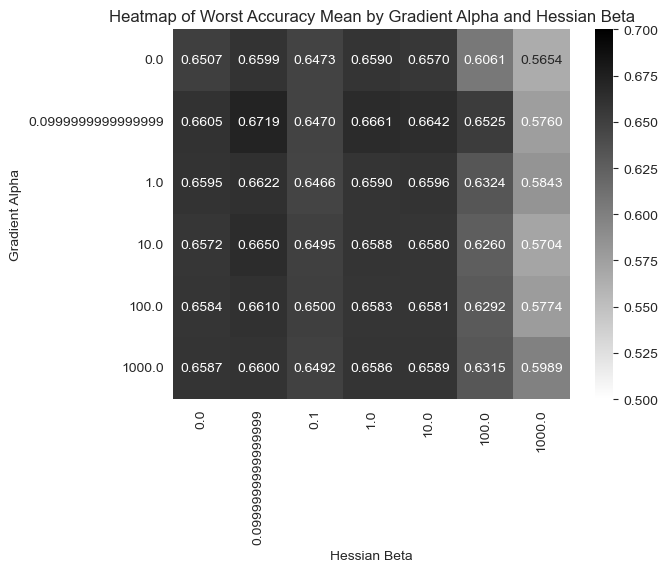

In [106]:
sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
plt.title('Heatmap of Worst Accuracy Mean by Gradient Alpha and Hessian Beta')
plt.xlabel('Hessian Beta')
plt.ylabel('Gradient Alpha')
plt.show()

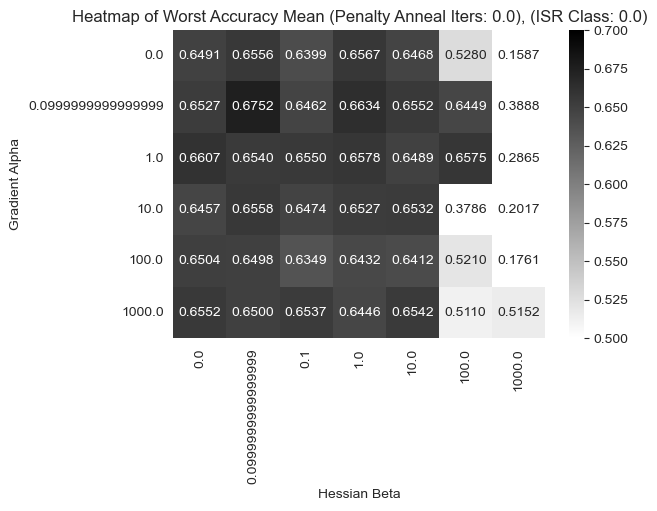

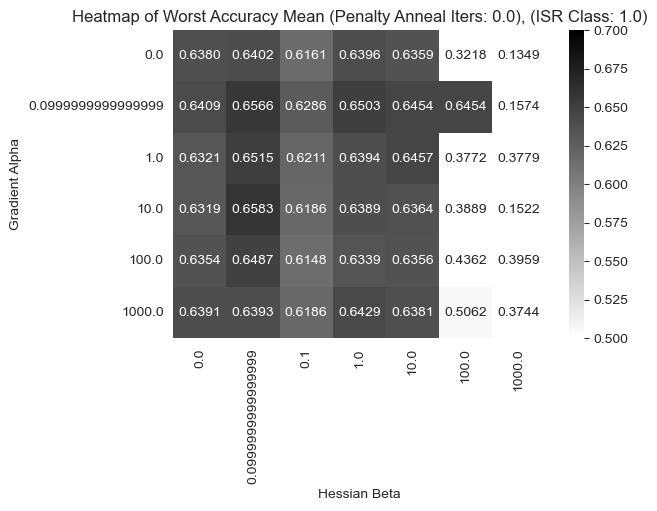

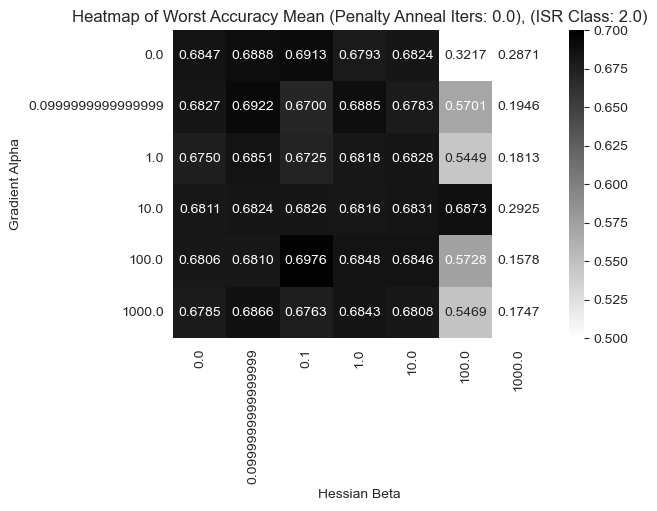

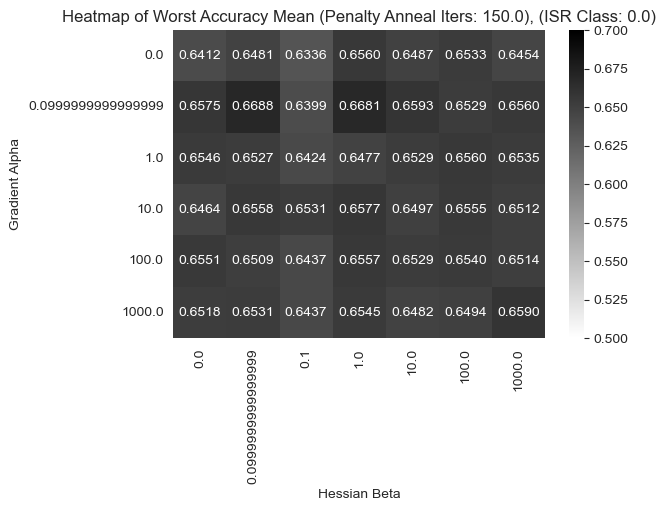

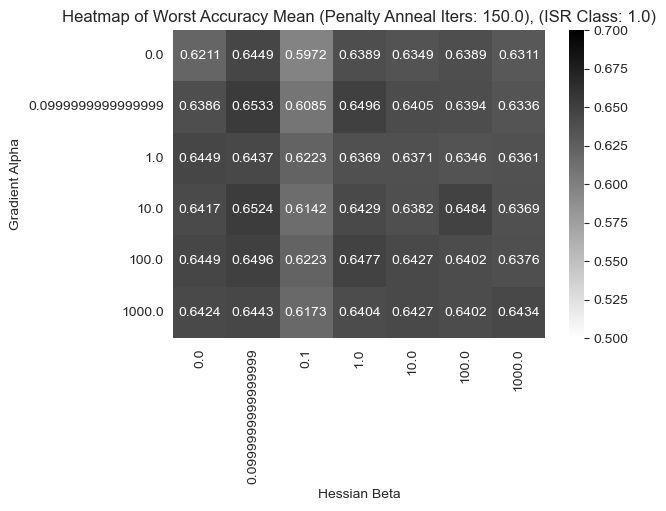

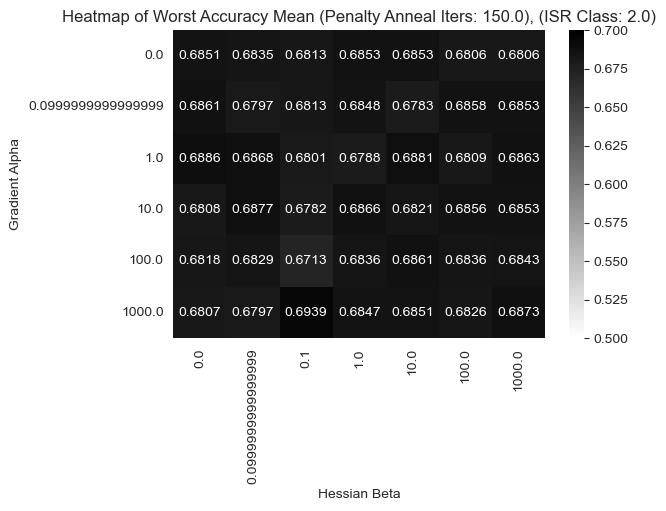

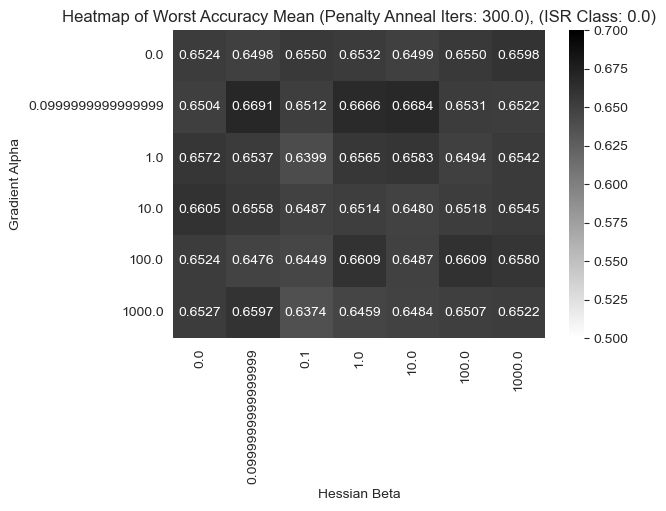

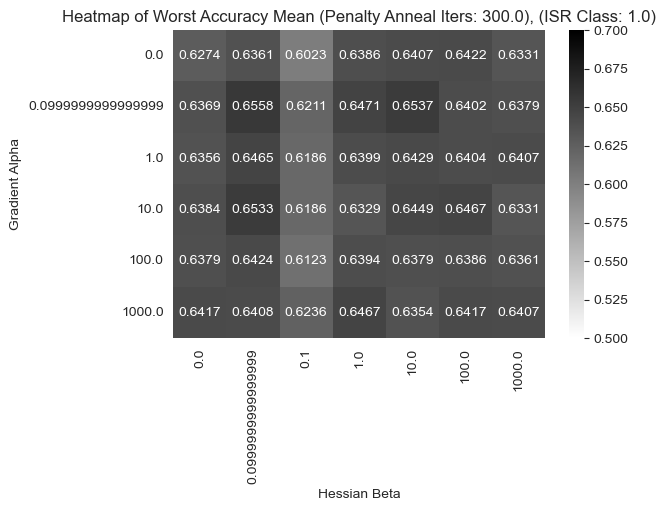

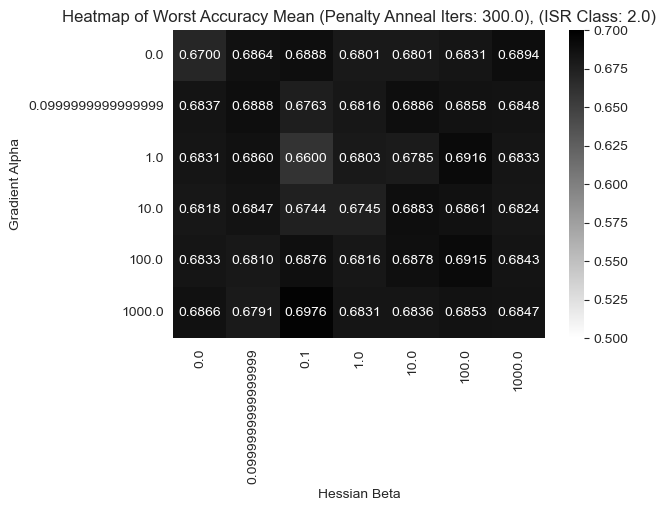

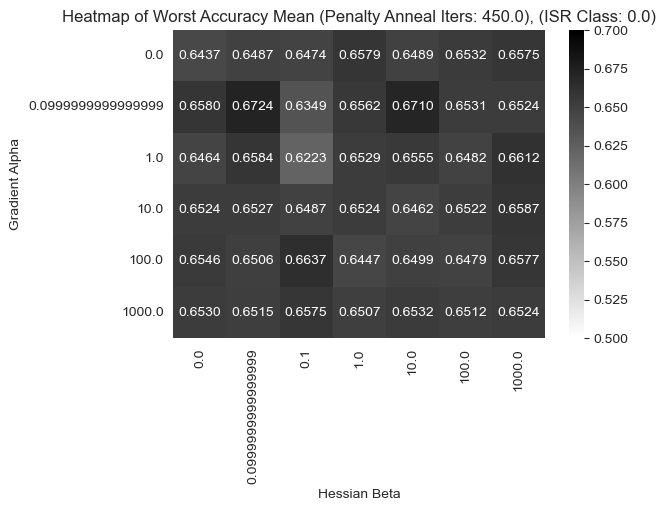

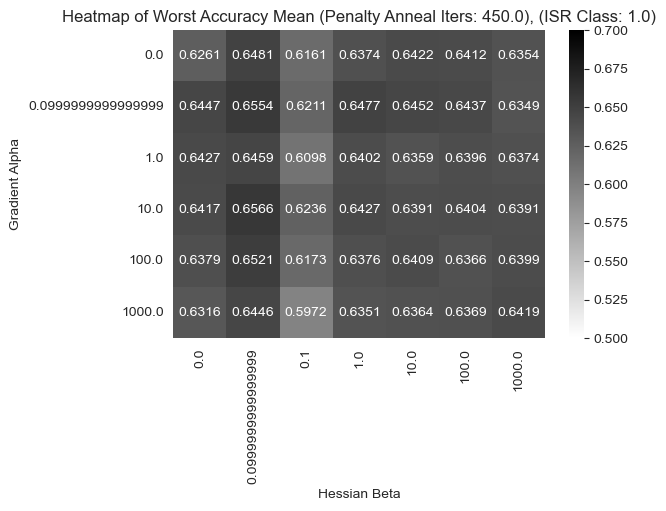

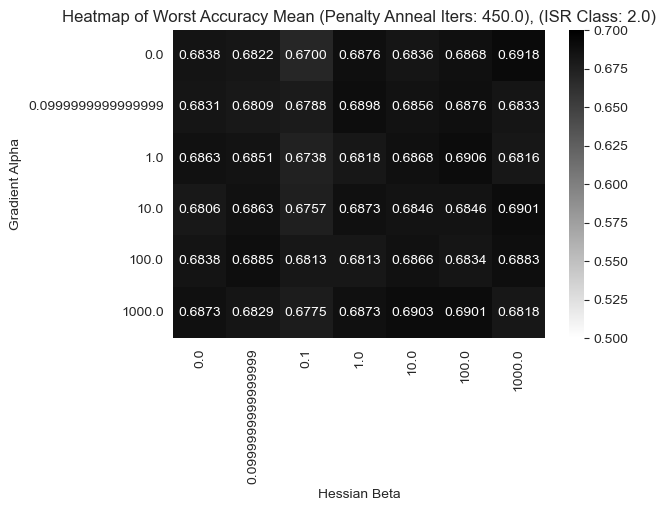

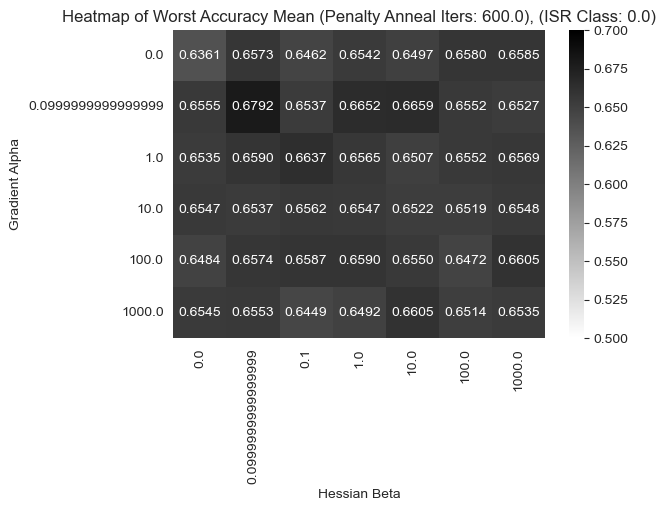

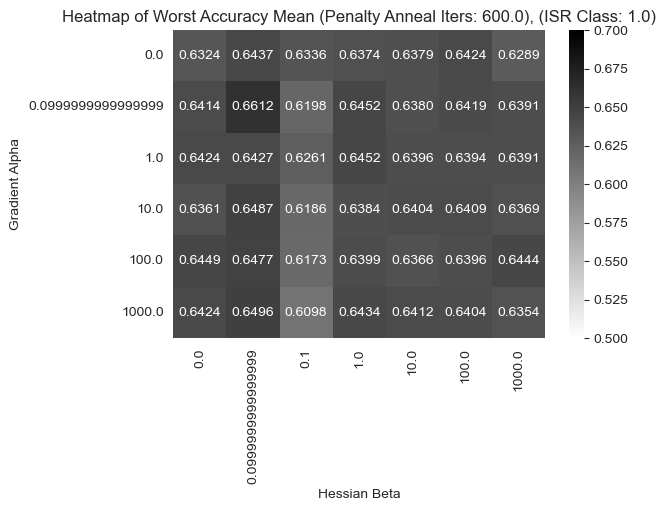

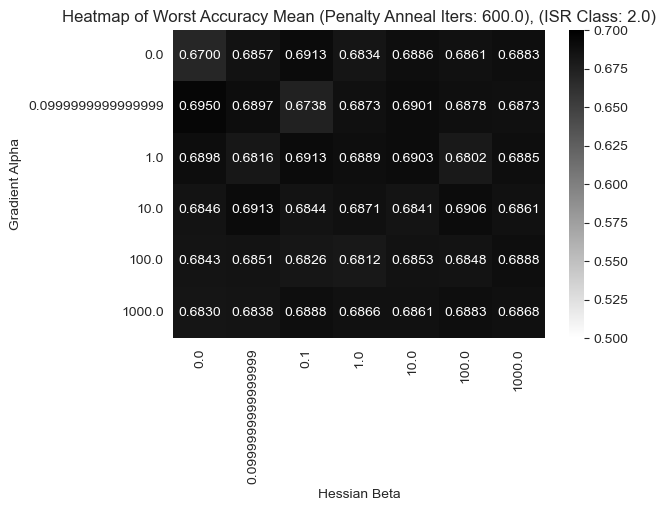

In [107]:
# We can create multiple heatmaps for each unique pairs value of 'ISR_class'and 'penalty_anneal_iters'
from itertools import product
unique_iters = product(df['penalty_anneal_iters'].unique(), df['ISR_class'].unique())
# unique_iters = df['penalty_anneal_iters'].unique()

for iters, isr_class in unique_iters:
    sub_df = df[df['penalty_anneal_iters'] == iters]
    sub_df = sub_df[sub_df['ISR_class'] == isr_class]
    pivot_df = sub_df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
    plt.title(f'Heatmap of Worst Accuracy Mean (Penalty Anneal Iters: {iters}), (ISR Class: {isr_class})')
    plt.xlabel('Hessian Beta')
    plt.ylabel('Gradient Alpha')
    plt.show()
